#  ADVANCED LANE FINDING

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
%matplotlib inline

## Counting nx, ny from image


(721, 1281, 3)


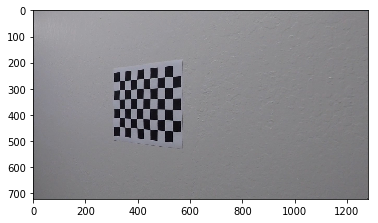

In [2]:
img = mpimg.imread("camera_cal/calibration7.jpg")
print(img.shape)
plt.imshow(img)

## Camera Calibration

In [3]:
# count nx, ny from above image
# camera calibration
def calibrate_camera(images, nx=9, ny=6):
    # prepare object points
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    objpoints = []
    imgpoints = []
    # step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # if found, add object points and image points
        if ret==True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    if len(objpoints)>0:
            print("Camera Calibrated")
            img_size = (img.shape[1],img.shape[0])
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    else:
            print("camera not calibrated")
            
    return ret, mtx, dist, rvecs, tvecs
images = glob.glob("camera_cal/calibration*.jpg")
ret, mtx, dist, rvecs, tvecs = calibrate_camera(images)
    

Camera Calibrated


## undistorting the image and testing

True

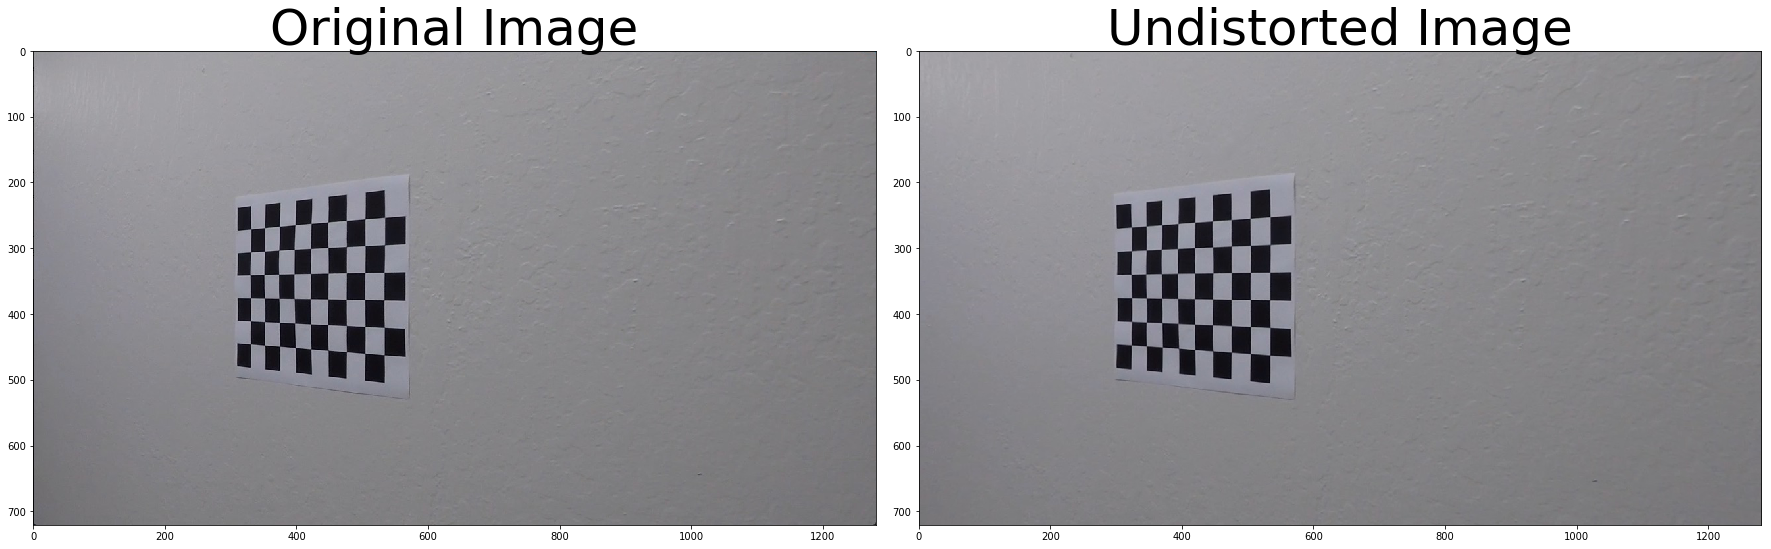

In [4]:
# using camera matrix and distortion coefficients undistorting the image
img = mpimg.imread("camera_cal/calibration7.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)

f,(ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist, cmap = 'gray')
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
cv2.imwrite("output_images/undistorted_image.jpg", undist)

##  Gradient threshold and Color Transform

In [5]:
def abs_sobel_threshold(gray, orient='x', sobel_kernel=3, thresh=(0,255)) :
    if orient=='x' :
        abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F,1,0))
        scale_factor = np.max(abs_sobelx)/255
        scaled_model = (abs_sobelx/scale_factor).astype(np.uint8)

    elif orient=='y':
        abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F,0,1))
        scale_factor = np.max(abs_sobely)/255
        scaled_model = (abs_sobely/scale_factor).astype(np.uint8)

    grad_binary = np.zeros_like(scaled_model)
    grad_binary[(scaled_model>=thresh[0]) & (scaled_model<=thresh[1])] = 1
    return grad_binary

def dir_threshold(gray, sobel_kernel=3, thresh=(0,np.pi/2)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1, ksize = sobel_kernel)
    abs_grad = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(abs_grad)
    dir_binary[(abs_grad>=thresh[0]) & (abs_grad<=thresh[1])] = 1
    return dir_binary

def threshold_img(img):
    img = cv2.undistort(img, mtx, None, mtx)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    # applying gradient threshold on horizontal gradient
    sx_binary = abs_sobel_threshold(gray, 'x', (10,200))
    
    # applying direction threshold so that vertical edges arre detected
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    combined_threshold = ((sx_binary==1) & (dir_binary==1))
    
    # R and G thresholds so that yellow lines are detected
    color_threshold = 150
    r = img[:,:,0]
    g = img[:,:,1]
    combined_color = np.zeros_like(r)
    r_g_combined = (r>color_threshold) & (g>color_threshold)
    
    # color channels threshold
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l = hls[:,:,1]
    s = hls[:,:,2]
    
    s_thresh = (100,255)
    s_condition  = (s> s_thresh[0]) & (s<=s_thresh[1])
    
    l_thresh = (120,255)
    l_condition = (l>l_thresh[0]) & (l<=l_thresh[1])
    
    combined_color[(r_g_combined & l_condition) & (s_condition | combined_threshold)] = 1
    mask = np.zeros_like(combined_color)
    region_of_interest = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest], 1)
    threshold = cv2.bitwise_and(mask, combined_color)
    return threshold

##  Binary Thresholded Image

True

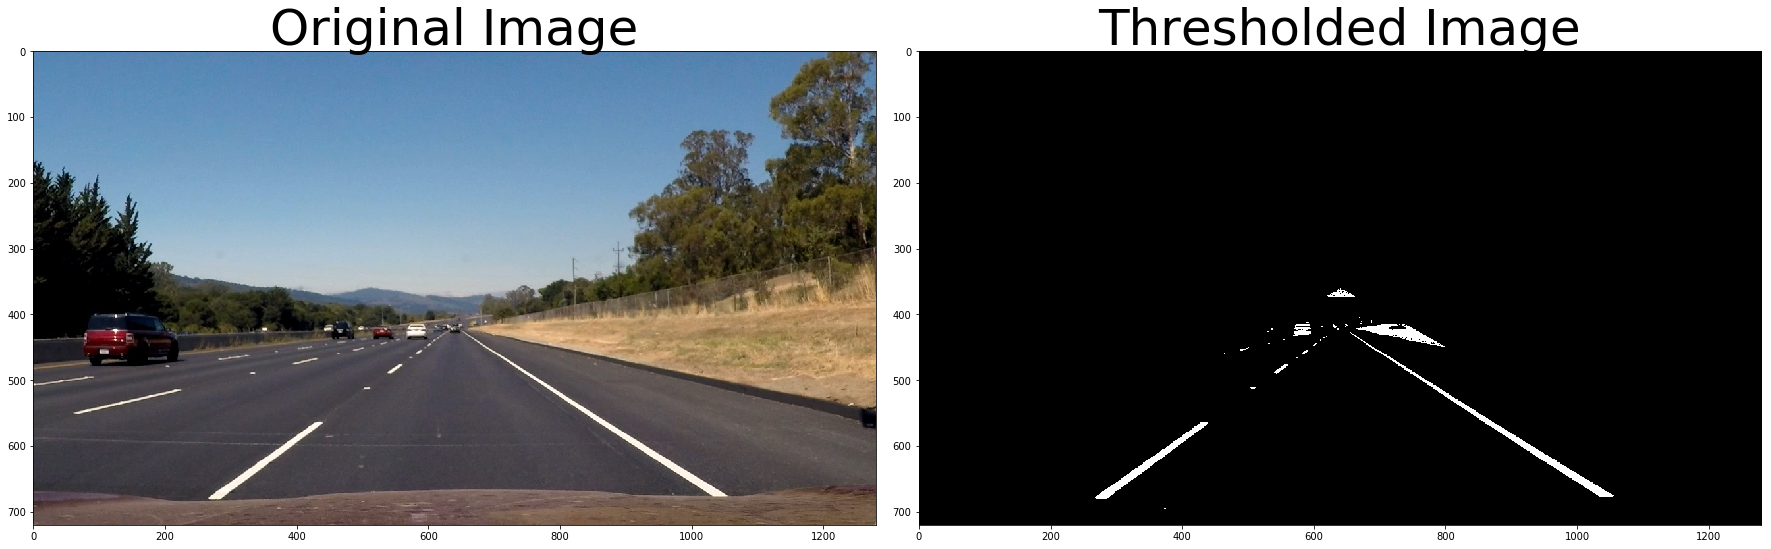

In [6]:
img = mpimg.imread('test_images/straight_lines2.jpg')
thresholded_img = threshold_img(img)
undist_img = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('thresholded.jpg',thresholded_img)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded_img, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
cv2.imwrite("output_images/thresholded_image.jpg", thresholded_img)

## Perspective Transform

True

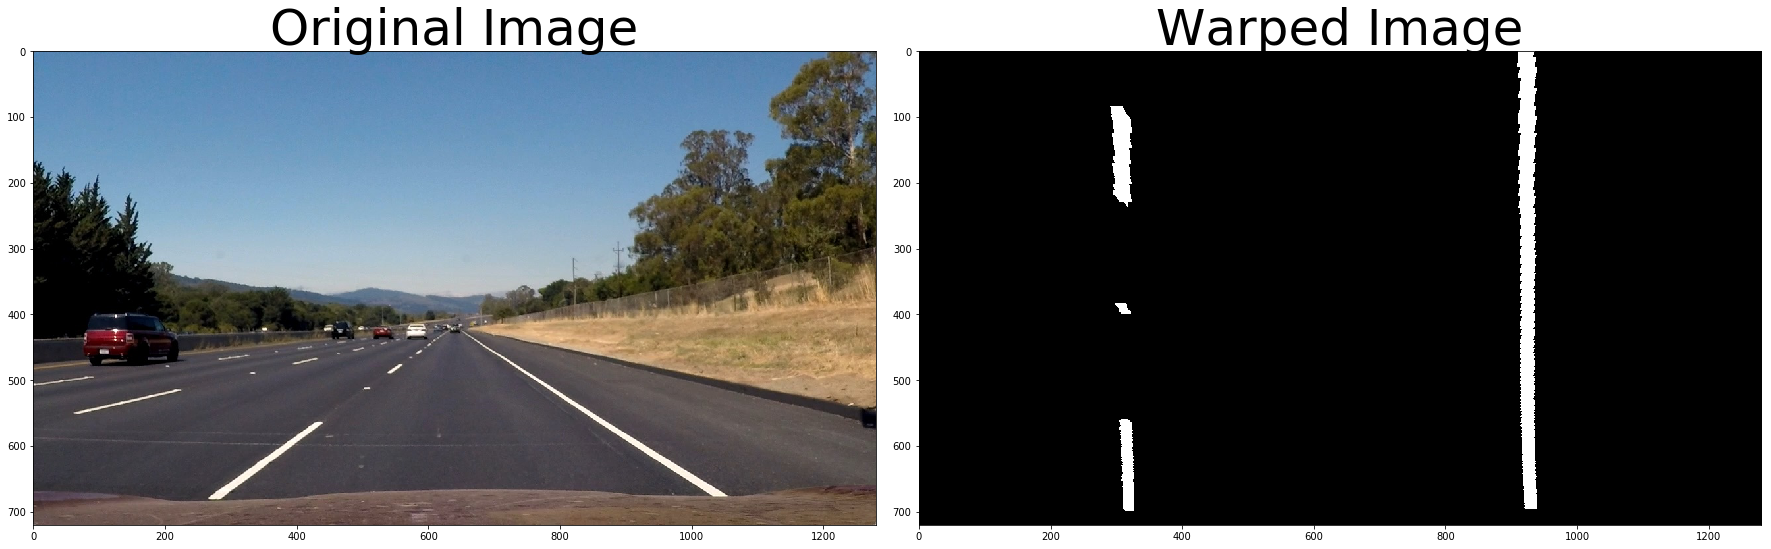

In [7]:
# perspective transform
src_pts = np.float32([[220,720], [1100,720], [570, 470], [720,470]])
dst_pts = np.float32([[320,720], [920,720], [320,0],[920,0]])
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
Minv = cv2.getPerspectiveTransform(dst_pts, src_pts)
img_size = (img.shape[1], img.shape[0])
warped_img = cv2.warpPerspective(thresholded_img, M, img_size, flags = cv2.INTER_LINEAR)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_img, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
cv2.imwrite("output_images/warped_image.jpg", warped_img)


## Detecting Lane Pixels
    
    using Histogram to find the initial points of left and right lanes

313 920


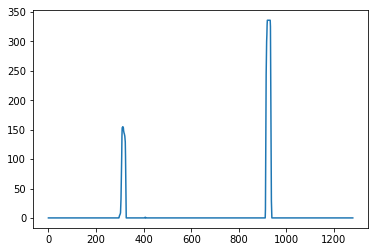

In [8]:
# peaks in the histogram tells the position of lanes in the image
histogram = np.sum(warped_img[warped_img.shape[0]//2:, :], axis = 0)
# peaks in the first half indicates left_lane
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
# peak in the second half indicates right lane
rightx_base = np.argmax(histogram[midpoint:])+ midpoint
print(leftx_base, rightx_base)
plt.plot(histogram)

## Sliding Window Search

True

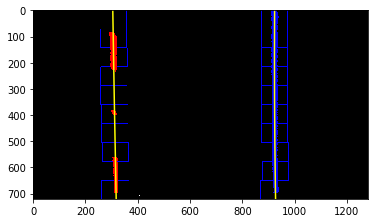

In [9]:
# sliding window search
out_img = np.dstack((warped_img, warped_img, warped_img))*255
nonzeros = warped_img.nonzero()
nonzeros_y = nonzeros[0]
nonzeros_x = nonzeros[1]

nwindows =10
margin =50
minpix =100
n_rows =warped_img.shape[0]
window_height = np.int(n_rows/nwindows)

left_coordinates = []
right_coordinates = []

for window in range(nwindows):
    ymax =n_rows-(window*window_height)
    ymin =n_rows-((window+1)*window_height)
    leftx_max = leftx_base+margin
    leftx_min = leftx_base-margin
    rightx_max = rightx_base+margin
    rightx_min = rightx_base-margin
    
    cv2.rectangle(out_img, (leftx_min, ymin), (leftx_max, ymax), [0,0,255], 2)
    good_left_window_coordinates =((nonzeros_x>=leftx_min)&(nonzeros_x<=leftx_max)&(nonzeros_y>=ymin)&(nonzeros_y<=ymax)).nonzero()[0]
    left_coordinates.append(good_left_window_coordinates)
    
    if len(good_left_window_coordinates)>minpix:
        leftx_base =np.int(np.mean(nonzeros_x[good_left_window_coordinates]))
        
    cv2.rectangle(out_img, (rightx_min, ymin), (rightx_max, ymax), [0,0,255], 2)
    good_right_window_coordinates =((nonzeros_x>=rightx_min)&(nonzeros_x<=rightx_max)&(nonzeros_y>=ymin)&(nonzeros_y<=ymax)).nonzero()[0]
    right_coordinates.append(good_right_window_coordinates)
    
    if len(good_right_window_coordinates)>minpix:
        rightx_base =np.int(np.mean(nonzeros_x[good_right_window_coordinates]))   

left_coordinates = np.concatenate(left_coordinates)
right_coordinates = np.concatenate(right_coordinates)
out_img[nonzeros_y[left_coordinates], nonzeros_x[left_coordinates]] = [255,0,0]
out_img[nonzeros_y[right_coordinates], nonzeros_x[right_coordinates]] = [0,0,255]

left_x=  nonzeros_x[left_coordinates]
left_y = nonzeros_y[left_coordinates]
right_x = nonzeros_x[right_coordinates]
right_y = nonzeros_y[right_coordinates]

left_polyfit = np.polyfit(left_y, left_x, 2)
right_polyfit  = np.polyfit(right_y, right_x, 2)

ploty = np.linspace(0,n_rows-1, n_rows)
leftx_values = (left_polyfit[0]*ploty**2) + (left_polyfit[1]*ploty) + left_polyfit[2]
rightx_values = (right_polyfit[0]*ploty**2) + (right_polyfit[1]*ploty) + right_polyfit[2]

plt.imshow(out_img)
plt.plot(leftx_values, ploty, color='yellow')
plt.plot(rightx_values, ploty, color='yellow')
plt.xlim(0, warped_img.shape[1])
plt.ylim(warped_img.shape[0],0)
cv2.imwrite("output_images/sliding_window.jpg", out_img)


## Search around previously detected lines

True

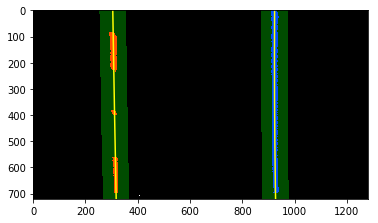

In [10]:
margin = 50
out_img = np.dstack((warped_img, warped_img, warped_img))*255
leftx_values = (left_polyfit[0]*nonzeros_y**2) + (left_polyfit[1]*nonzeros_y) + left_polyfit[2]
left_coordinates =((nonzeros_x >= leftx_values-margin)&(nonzeros_x <= leftx_values+margin)).nonzero()[0]
rightx_values = (right_polyfit[0]*nonzeros_y) + (right_polyfit[1]*nonzeros_y) + right_polyfit[2]
right_coordinates =((nonzeros_x >= rightx_values-margin)&(nonzeros_x <= rightx_values+margin)).nonzero()[0]
out_img[nonzeros_y[left_coordinates], nonzeros_x[left_coordinates]] = [255,0,0]
out_img[nonzeros_y[right_coordinates], nonzeros_x[right_coordinates]] = [0,0,255]

left_x=  nonzeros_x[left_coordinates]
left_y = nonzeros_y[left_coordinates]
right_x = nonzeros_x[right_coordinates]
right_y = nonzeros_y[right_coordinates]

left_polyfit = np.polyfit(left_y, left_x, 2)
right_polyfit  = np.polyfit(right_y, right_x, 2)

ploty = np.linspace(0,n_rows-1, n_rows)
leftx_values = (left_polyfit[0]*ploty**2) + (left_polyfit[1]*ploty) + left_polyfit[2]
rightx_values = (right_polyfit[0]*ploty**2) + (right_polyfit[1]*ploty) + right_polyfit[2]

window_img = np.zeros_like(out_img)

left_line_window1 = np.array(np.transpose(np.vstack([leftx_values-margin, ploty])))
left_line_window2 = np.array(np.flipud(np.transpose(np.vstack([leftx_values+margin,ploty])))) 
left_line_pts = np.vstack((left_line_window1, left_line_window2))
right_line_window1 = np.array(np.transpose(np.vstack([rightx_values-margin, ploty])))
right_line_window2 = np.array(np.flipud(np.transpose(np.vstack([rightx_values+margin,ploty]))))
right_line_pts = np.vstack((right_line_window1, right_line_window2))

# # Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), [0,255, 0])
cv2.fillPoly(window_img, np.int_([right_line_pts]), [0,255, 0])
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

# # Plot the polynomial lines onto the image
plt.imshow(result)
plt.plot(leftx_values, ploty, color='yellow')
plt.plot(rightx_values, ploty, color='yellow')
plt.xlim(0, warped_img.shape[1])
plt.ylim(warped_img.shape[0],0)
cv2.imwrite("output_images/search_previous.jpg", result)

## Finding Radius of curvature and Center offset

In [11]:
# computing the radius of curvature and center offset
def measure_radius_of_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    ploty = np.linspace(0, n_rows-1, n_rows)
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

left_curve_rad = measure_radius_of_curvature(leftx_values)
right_curve_rad = measure_radius_of_curvature(rightx_values)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
print(curvature_string)

# compute the offset from the center
lane_center = (rightx_values[719] + leftx_values[719])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(offset_string)

Radius of curvature: 32945.46 m
Center offset: 0.09 m


## Painting Lane Area and Inverse Transform

True

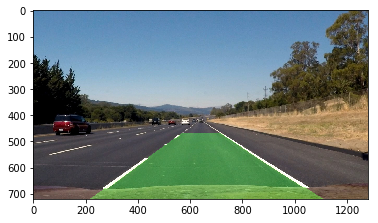

In [12]:
# painting the lane area and perform inverse perspective transform
out_img = np.dstack((warped_img, warped_img, warped_img))*255
ploty = np.linspace(0, n_rows-1, n_rows)
left_line_window = np.array(np.transpose(np.vstack([leftx_values, ploty])))
right_line_window = np.array(np.flipud(np.transpose(np.vstack([rightx_values, ploty]))))
line_pts = np.vstack((left_line_window, right_line_window))
cv2.fillPoly(out_img, np.int_([line_pts]), [0,255, 0])
unwarped_img = cv2.warpPerspective(out_img,Minv, img_size, flags = cv2.INTER_LINEAR)
result = cv2.addWeighted(img, 1, unwarped_img, 0.3, 0)
plt.imshow(result)
cv2.imwrite("output_images/painted_image.jpg", result)

## Final Pipeline

In [13]:
left_polyfit = None
right_polyfit = None

previous_good_left_lines = []
previous_good_right_lines = []
mean_difference_between_lines = 0


# this function gives the prediction for the lane lines
def line_values(nonzeros_x, nonzeros_y, left_coordinates, right_coordinates, n_rows):
    left_x=  nonzeros_x[left_coordinates]
    left_y = nonzeros_y[left_coordinates]
    
    if(left_y.size==0) or (left_x.size==0):
        return None, None
    right_x = nonzeros_x[right_coordinates]
    right_y = nonzeros_y[right_coordinates]
    
    if(right_y.size==0) or (right_x.size==0):
        return None, None
    
    left_polyfit = np.polyfit(left_y, left_x, 2)
    right_polyfit  = np.polyfit(right_y, right_x, 2)

    ploty = np.linspace(0,n_rows-1, n_rows)
    leftx_values = (left_polyfit[0]*ploty**2) + (left_polyfit[1]*ploty) + left_polyfit[2]
    rightx_values = (right_polyfit[0]*ploty**2) + (right_polyfit[1]*ploty) + right_polyfit[2]
    
    return leftx_values, rightx_values

# If polynomial coefficients of previous frames are none, then we do brute search
def brute_search(warped_img):
    out_img = np.dstack((warped_img, warped_img, warped_img))*255
    nonzeros = warped_img.nonzero()
    nonzeros_y = nonzeros[0]
    nonzeros_x = nonzeros[1]
    
    histogram = np.sum(warped_img[warped_img.shape[0]//2:, :], axis = 0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+ midpoint

    nwindows =10
    margin =50
    minpix =100
    n_rows =warped_img.shape[0]
    window_height = np.int(n_rows/nwindows)

    left_coordinates = []
    right_coordinates = []

    for window in range(nwindows):
        ymax =n_rows-(window*window_height)
        ymin =n_rows-((window+1)*window_height)
        leftx_max = leftx_base+margin
        leftx_min = leftx_base-margin
        rightx_max = rightx_base+margin
        rightx_min = rightx_base-margin

        good_left_window_coordinates =((nonzeros_x>=leftx_min)&(nonzeros_x<=leftx_max)&(nonzeros_y>=ymin)&(nonzeros_y<=ymax)).nonzero()[0]
        left_coordinates.append(good_left_window_coordinates)

        if len(good_left_window_coordinates)>minpix:
            leftx_base =np.int(np.mean(nonzeros_x[good_left_window_coordinates]))

        good_right_window_coordinates =((nonzeros_x>=rightx_min)&(nonzeros_x<=rightx_max)&(nonzeros_y>=ymin)&(nonzeros_y<=ymax)).nonzero()[0]
        right_coordinates.append(good_right_window_coordinates)

        if len(good_right_window_coordinates)>minpix:
            rightx_base =np.int(np.mean(nonzeros_x[good_right_window_coordinates]))   

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)
    leftx_values, rightx_values = line_values(nonzeros_x, nonzeros_y, left_coordinates, right_coordinates, n_rows)
    return leftx_values, rightx_values

# The lane for each frame is an average of previously computed lanes
def averaged_lines(previous_lines, new_line):
    num_frames = 12
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line
        
        
def mean_distance_between_lines(left_line, right_line, running_average):
    """
        Returns running weighted average of simple difference between left and right lines
    """
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average
    

def pipeline_final(img):
    global right_polyfit
    global left_polyfit
    
    global previous_good_right_lines
    global previous_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global mean_difference_between_lines
    
    img_shape = img.shape
    img_size = (img_shape[1], img_shape[0])
    
    thresholded_img = threshold_img(img)
    
    warped_img = cv2.warpPerspective(thresholded_img, M, img_size , flags=cv2.INTER_LINEAR)
    
    out_img = np.dstack((warped_img, warped_img, warped_img))*255
    
    non_zeros = warped_img.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    n_rows = warped_img.shape[0]
    ploty = np.linspace(0, n_rows-1, n_rows)
    
    if (left_polyfit is None) or (right_polyfit is None):
        # If the polynomial coefficients of the previous frames are None then perform a brute force search
        brute = True
        leftx_values, rightx_values = brute_search(warped_img)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        brute = False
        margin = 100
        leftx_values = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
        left_coordinates = ((non_zeros_x >= leftx_values - margin) & (non_zeros_x <= leftx_values + margin)).nonzero()[0]

        rightx_valuess = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
        right_coordinates = ((non_zeros_x >= rightx_values - margin) & (non_zeros_x <= rightx_values + margin)).nonzero()[0]
        
        leftx_values, rightx_values = line_values(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, n_rows)
    
    if (leftx_values is None or rightx_values is None):
        if not brute:
            leftx_values, rightx_values = brute_search(warped_img)
            
    bad_lines = False
            
    if (leftx_values is None or rightx_values is None):
        bad_lines = True
    else:
        mean_difference = np.mean(rightx_values - leftx_values)
        
        if mean_difference_between_lines == 0:
            mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*mean_difference_between_lines or mean_difference > 1.3*mean_difference_between_lines):
            bad_lines = True
            if not brute:
                leftx_values, rightx_values = brute_search(warped_img)
                if (leftx_values is None or rightx_values is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(rightx_values - leftx_values)
                    if (mean_difference < 0.7*mean_difference_between_lines or mean_difference > 1.3*mean_difference_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        left_polyfit = None
        right_polyfit = None
        if len(previous_good_left_lines) == 0 and len(previous_good_right_lines) == 0:
            return img
        else:
            leftx_values = previous_good_left_lines[-1]
            rightx_values = previous_good_right_lines[-1]
    else:
        previous_good_left_lines, leftx_values = averaged_lines(previous_good_left_lines, leftx_values)
        previous_good_right_lines, rightx_values = averaged_lines(previous_good_right_lines, rightx_values)
        mean_difference = np.mean(rightx_values - leftx_values)
        mean_difference_between_lines = 0.9*mean_difference_between_lines + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([leftx_values, ploty])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([rightx_values, ploty]))))
    
    # compute the radius of curvature
    left_curve_rad = measure_radius_of_curvature(leftx_values)
    right_curve_rad = measure_radius_of_curvature(rightx_values)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (rightx_values[n_rows-1] + leftx_values[n_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    poly_points = np.vstack([left_line_window, right_line_window])
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    unwarped_img = cv2.warpPerspective(out_img,Minv, img_size, flags = cv2.INTER_LINEAR)
    result = cv2.addWeighted(img, 1, unwarped_img, 0.3, 0)
    
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

In [14]:
from moviepy.editor import VideoFileClip

## PROJECT VIDEO OUTPUT

In [15]:
# Reinitialize some global variables.
left_polyfit = None
right_polyfit = None
previous_good_right_lines = []
previous_good_left_lines = []
mean_difference_between_lines = 0


output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:51<00:00,  3.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 12s, sys: 31 s, total: 3min 43s
Wall time: 5min 54s


## CHALLENGE VIDEO

In [16]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0


output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [02:16<00:00,  3.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 18s, sys: 9.96 s, total: 1min 28s
Wall time: 2min 19s


## HARDER CHALLENGE VIDEO

In [17]:
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0


output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [09:25<00:00,  3.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 3min 55s, sys: 22.8 s, total: 4min 18s
Wall time: 9min 29s
